# CSCI 111 Final Project: [TITLE]

Albel, Rasheed

Eltagonde, Val Allen

Layug, Franz Andrei

***

#### Executive Summary 📖
Abstract-like. Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
#### Problem Statement 🙋‍♂️
In the contemporary landscape of data-driven decision making, it has become increasingly crucial to understand the dynamics of societal economics at a granular level. This report aims to analyze the "Adult Census Income" dataset to predict the income level of individuals based on various sociodemographic factors. Specifically, the analysis aims to create a binary classifier to predict if an individual's income exceeds $50K per year.
#### Motivation 💡
The motivation behind this study is twofold: from a sociological perspective, this report could provide crucial insights into the factors affecting income distribution in society. From a machine learning perspective, the study presents an opportunity to apply various machine learning models and determine their effectiveness in a real-world context.

# Importing Packages and Dataset

In [23]:
# Exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Data preparation
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Model creation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, roc_curve

sns.set_style('whitegrid')
sns.set_palette('crest')

In [24]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"]

df = pd.read_csv('census+income/adult.data', names=columns)

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Initial Data Cleaning 🧹

In [25]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [26]:
# Remove duplicates
df = df[~df.duplicated()]

In [27]:
# Discard whitespace
columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
for column in columns:
    df[column] = df[column].str.strip()

In [28]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

# Exploratory Data Analysis 🔍

### Preliminary Investigation
The dataset contains various quantitative and categorical variable including age, education, and race. There is also a `fnlwgt` column prepared by the Census Bureau used to control the independent estimates of the US civilian non-institutional population. According to the dataset source, three sets of controls were used:
- A single cell estimate of the population 16+ for each state.
- Controls for Hispanic Origin by age and sex.
- Controls by Race, age and sex.

In [29]:
df.shape

(32537, 15)

### Age Distribution 🧑‍🤝‍🧑
"What is the age distribution of the population in the dataset? Does a specific age group dominate the dataset?"

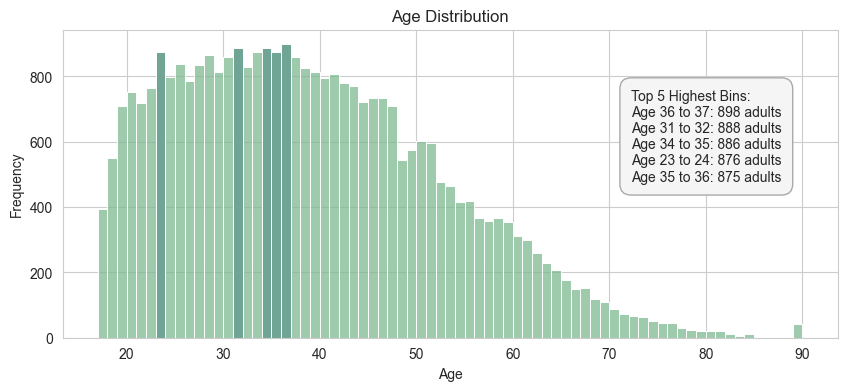

In [30]:
plt.figure(figsize=(10,4))
age_range = df.age.max() - df.age.min()
ax = sns.histplot(df.age,bins=age_range)

counts, bin_edges, patches = ax.hist(df.age, bins=age_range, alpha=0)
top_indices = np.argsort(counts)[::-1][:5]
top_5 = '\n'.join([f'Age {int(bin_edges[i])} to {int(bin_edges[i+1])}: {int(counts[i])} adults' for i in top_indices])
plt.text(72.25, 480, f'Top 5 Highest Bins:\n{top_5}',bbox=dict(facecolor='whitesmoke', edgecolor='darkgray', boxstyle='round', pad=0.8))
for i in top_indices:
    ax.patches[i].set_facecolor('#70a494')

plt.title('Age Distribution', size='large')
plt.ylabel('Frequency')
plt.xlabel('Age')

plt.show()

### Income by Workclass ⚒️
"Does income level differ significantly across different work classes? If so, which work classes tend to earn more or less?"

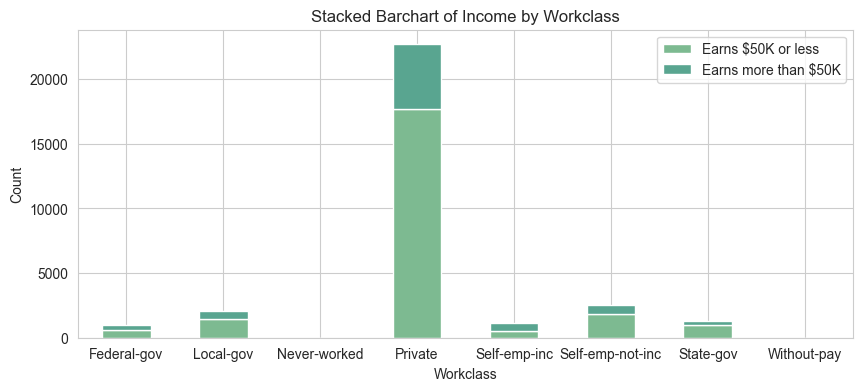

In [31]:
df_workclass = df.groupby(['workclass','income']).size().reset_index(name='count')
df_workclass = df_workclass.pivot(index='workclass', columns='income', values='count').reset_index()
df_workclass = df_workclass.copy().iloc[1:,:] # Remove the '?' category

df_workclass.set_index('workclass').plot(kind='bar', stacked=True, figsize=(10,4))

plt.xticks(rotation=0)
plt.title('Stacked Barchart of Income by Workclass', size='large')
plt.ylabel('Count')
plt.xlabel('Workclass')
plt.legend(['Earns $50K or less', 'Earns more than $50K'])

plt.show()

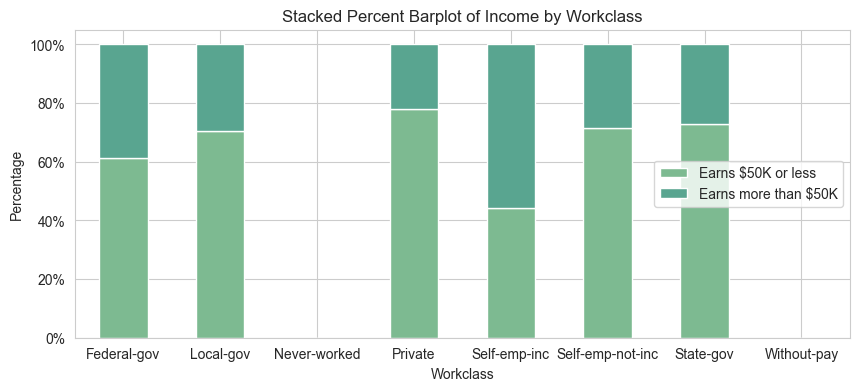

In [32]:
df_workclass['<=50K_p'] = df_workclass['<=50K'] / (df_workclass['<=50K'] + df_workclass['>50K'])
df_workclass['>50K_p'] = df_workclass['>50K'] / (df_workclass['<=50K'] + df_workclass['>50K'])
df_workclass_percent = df_workclass[['workclass', '<=50K_p', '>50K_p']]

df_workclass_percent.set_index('workclass').plot(kind='bar', stacked=True, figsize=(10,4))

plt.xticks(rotation=0)
plt.title('Stacked Percent Barplot of Income by Workclass', size='large')
plt.ylabel('Percentage')
plt.xlabel('Workclass')
plt.legend(['Earns $50K or less', 'Earns more than $50K'],loc=7)

y_formatter = mtick.FuncFormatter(lambda y, _: f'{int(y*100)}%')
plt.gca().yaxis.set_major_formatter(y_formatter)

plt.show()

### Education Level and Income 🎓
"Is there a relationship between the level of education and income? Do individuals with higher levels of education generally earn more?"

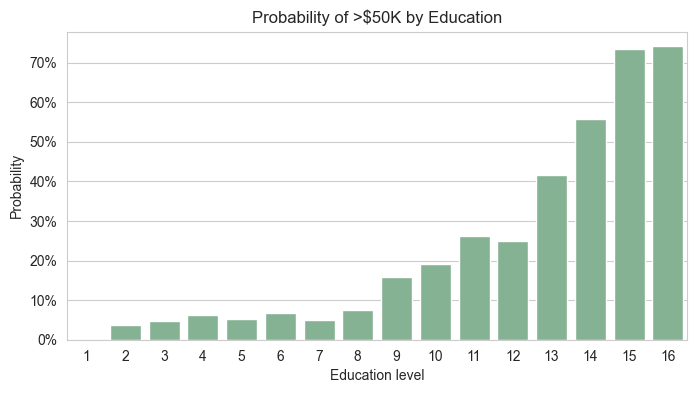

In [33]:
df_educlevel = df.groupby(['education_num', 'income']).size().reset_index(name='count')
df_educlevel = df_educlevel.pivot(index='education_num', columns='income', values='count').reset_index()
df_educlevel['>50K_p'] = df_educlevel['>50K'] / (df_educlevel['<=50K'] + df_educlevel['>50K'])

plt.figure(figsize=(8, 4))
ax = sns.barplot(data=df_educlevel, x='education_num', y='>50K_p')

plt.xticks(rotation=0)
plt.title('Probability of >$50K by Education', size='large')
plt.ylabel('Probability')
plt.xlabel('Education level')

# Format y-axis as percentages
y_formatter = mtick.FuncFormatter(lambda y, _: f'{int(y * 100)}%')
plt.gca().yaxis.set_major_formatter(y_formatter)

plt.show()

### Hours per Week and Income ⌛
"Is there a correlation between the number of hours worked per week and income? Do people who work more hours generally have a higher income?"

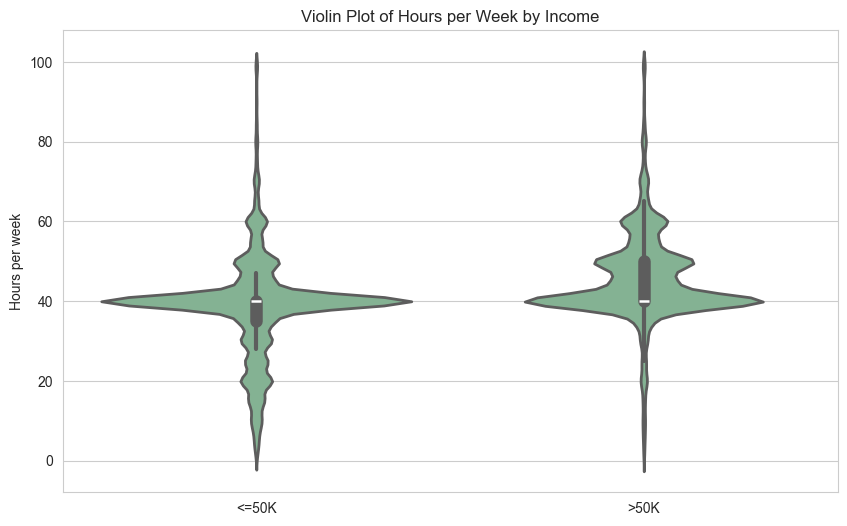

In [34]:
df_hours = df[['income','hours_per_week']]

plt.figure(figsize=(10,6))
sns.violinplot(data=df_hours, x='income', y='hours_per_week', linewidth=2)

plt.title('Violin Plot of Hours per Week by Income', size='large')
plt.ylabel('Hours per week')
plt.xlabel('')

plt.show()

### Income Distribution by Sex and Race 🧑
"Are there disparities in income levels when broken down by sex and race? Does a specific gender or race tend to earn more?"

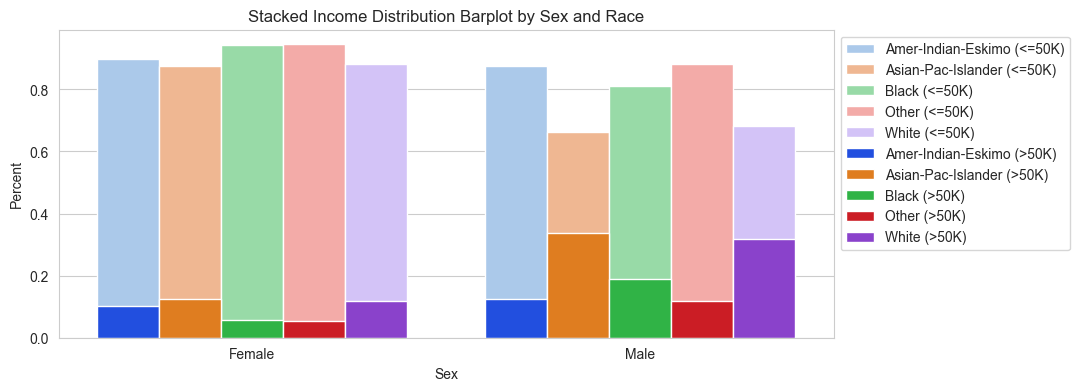

In [35]:
df_sexrace = df.groupby(['race','sex','income']).size().reset_index(name='count')
df_sexrace = df_sexrace.pivot(index=['sex','race'],columns='income', values='count').reset_index()
df_sexrace['<=50K_p'] = df_sexrace['<=50K'] / (df_sexrace['<=50K'] + df_sexrace['>50K'])
df_sexrace['>50K_p'] = df_sexrace['>50K'] / (df_sexrace['<=50K'] + df_sexrace['>50K'])
df_sexrace['bot'] = df_sexrace['>50K_p'] + df_sexrace['<=50K_p']

plt.figure(figsize=(10,4))
bar1 = sns.barplot(x='sex', y='<=50K_p', hue='race', data=df_sexrace, palette='pastel')
bar2 = sns.barplot(x='sex', y='>50K_p', hue='race', data=df_sexrace, palette='bright')

handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'{i} (<=50K)' if ind<5 else f'{i} (>50K)' for ind,i in enumerate(labels)]
bar1.legend(handles=handles, labels=labels, bbox_to_anchor=(1,1))

plt.title('Stacked Income Distribution Barplot by Sex and Race', size='large')
plt.ylabel('Percent')
plt.xlabel('Sex')

plt.show()

### Column Descriptions

In [36]:
# Ascertain which columns are categorical or quantitative (int64).
for column in df.columns:
    if not pd.api.types.is_numeric_dtype(df[column]):
        df[column] = df[column].astype('category')

# Display columns and descriptions
descriptions = column_descriptions = [
    "Age of the individual", "The employment sector where the individual works", "Final weight by Census Bureau",
    "The highest level of education achieved", "The highest level of education in numerical form", "The marital status of the individual",
    "The individual's general occupation or job role", "The individual's role in their family", "The individual's self-identified race",
    "The individual's self-identified sex", "Capital gains made by the individual", "Capital losses suffered by the individual",
    "The number of hours the individual works per week", "The native country of the individual", "The income level of the individual"]

pd.DataFrame({'Short description':descriptions,'Data type':df.dtypes, 'Null value count':df.isnull().sum()})

,Short description,Data type,Null value count
age,Age of the individual,int64,0
workclass,The employment sector where the individual works,category,0
fnlwgt,Final weight by Census Bureau,int64,0
education,The highest level of education achieved,category,0
education_num,The highest level of education in numerical form,int64,0
marital_status,The marital status of the individual,category,0
occupation,The individual's general occupation or job role,category,0
relationship,The individual's role in their family,category,0
race,The individual's self-identified race,category,0
sex,The individual's self-identified sex,category,0


# Data Preprocessing 🔬

In [37]:
# Replace categorical columns with "?" values to NAN
for column in columns:
    df[column] = df[column].replace({'?': np.nan})

In [38]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [39]:
# Drop NaN values
df.dropna(inplace=True)
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [40]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [45]:
# Assign x and y (input and output variables)
x = df.iloc[:, :-1]
y = df.income

In [49]:
categorical_features = x.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = x.select_dtypes(include=['int64']).columns.tolist()

numerical_features + categorical_features

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

### One-Hot Encoding and Standard Scaling

In [48]:
categorical_features = x.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = x.select_dtypes(include=['int64']).columns.tolist()

preprocessor = make_column_transformer(
        (StandardScaler(), numerical_features),
        (OneHotEncoder(), categorical_features),
        remainder='passthrough')

x_processed = preprocessor.fit_transform(x)

print(preprocessor.get_feature_names_out())


# Restore column names
ohe_categories = preprocessor.named_transformers_['onehotencoder'].categories_
ohe_feature_names = [f"{col}_{val}" for col, vals in zip(categorical_features, ohe_categories) for val in vals]
new_feature_names = numerical_features + ohe_feature_names

x_processed = pd.DataFrame(x_processed.toarray(), columns=new_feature_names)

['standardscaler__age' 'standardscaler__fnlwgt'
 'standardscaler__education_num' 'standardscaler__capital_gain'
 'standardscaler__capital_loss' 'standardscaler__hours_per_week'
 'onehotencoder__workclass_Federal-gov'
 'onehotencoder__workclass_Local-gov' 'onehotencoder__workclass_Private'
 'onehotencoder__workclass_Self-emp-inc'
 'onehotencoder__workclass_Self-emp-not-inc'
 'onehotencoder__workclass_State-gov'
 'onehotencoder__workclass_Without-pay' 'onehotencoder__education_10th'
 'onehotencoder__education_11th' 'onehotencoder__education_12th'
 'onehotencoder__education_1st-4th' 'onehotencoder__education_5th-6th'
 'onehotencoder__education_7th-8th' 'onehotencoder__education_9th'
 'onehotencoder__education_Assoc-acdm'
 'onehotencoder__education_Assoc-voc' 'onehotencoder__education_Bachelors'
 'onehotencoder__education_Doctorate' 'onehotencoder__education_HS-grad'
 'onehotencoder__education_Masters' 'onehotencoder__education_Preschool'
 'onehotencoder__education_Prof-school'
 'onehotenc

In [22]:
import pickle

with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

with open('preprocessing_feature_names.pkl', 'wb') as f:
    pickle.dump(new_feature_names, f)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_processed, y, train_size=0.80, random_state=42)

### Feature Selection

In [24]:
logreg = LogisticRegression(solver='lbfgs', max_iter=400)

selector = RFECV(logreg, step=1, cv=5, scoring='accuracy')
selector = selector.fit(X_train, y_train)

print(selector.ranking_)

[ 1  3  1  1  1  1  1  1 13  1  1  1  1 16  1  1  1  1  9  1  1  6  5 18
  7 19  1  1  8  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
  1 12  1 15  1  1  1  1  1  1  1  1 11  1 10  1  1  1  1  1  1  1  1  1
  1  1  1 14  1 20  1  1  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 17  1  1  1]


In [25]:
# Retain column names
selected_features_mask = selector.support_
selected_columns = X_train.columns[selected_features_mask]

X_train_fix_rfe = pd.DataFrame(selector.transform(X_train), columns=selected_columns)
X_test_fix_rfe = pd.DataFrame(selector.transform(X_test), columns=selected_columns)

In [26]:
print(f'Previous feature count: {X_test.shape[1]}')
print(f'Current feature count: {X_test_fix_rfe.shape[1]}')

Previous feature count: 104
Current feature count: 85


### Synthetic Minority Oversampling Technique (SMOTE)
We implement oversampling to account for imbalanced features revealed during the Exploratory Data Analysis process.

In [27]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_fix_rfe, y_train)

# Model Creation

## Logistic Regression 📈

In [85]:
param_grid = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}

# Run grid search
grid_search = GridSearchCV(LogisticRegression(C=1, penalty='l2'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3) # l2 is the common penalty for all solvers
grid_search.fit(X_train_smote, y_train_smote)

# Extract the best estimator
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9079107679715588
{'solver': 'sag'}


C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [86]:
# Find best parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100],
    'penalty': ['l2', None] # l1 is not applicable with the `sag` solver
}

# Run grid search
grid_search = GridSearchCV(LogisticRegression(solver='sag'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_smote, y_train_smote)

# Extract the best estimator
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.907910798344442
{'C': 1, 'penalty': 'l2'}


C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [88]:
# Find best parameters
param_grid = {
    'C': np.arange(0.8,1.2,0.05),
}

# Run grid search
grid_search = GridSearchCV(LogisticRegression(solver='sag', penalty='l2'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_smote, y_train_smote)

# Extract the best estimator
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.9079115267373774
{'C': 0.9000000000000001}


C:\Users\USER\.conda\envs\recweek_email_new\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [89]:
model_logreg = LogisticRegression(
    solver='sag',
    C=0.9,
    max_iter=4000,
    penalty='l2')

model_logreg.fit(X_train_smote, y_train_smote)

LogisticRegression(C=0.9, max_iter=4000, solver='sag')

## Random Forest Classifier 🌲

In [74]:
# Find best n_estimator
param_grid = { 
    'n_estimators': [100,200,500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_smote, y_train_smote)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
0.9177880936147556
{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200}


In [76]:
# Find best n_estimator
param_grid = { 
    'n_estimators': np.arange(150,250,25),
    'max_depth' : np.arange(12,20,30),
}

grid_search = GridSearchCV(RandomForestClassifier(criterion='gini'), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_smote, y_train_smote)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.9315962245472953
{'max_depth': 12, 'n_estimators': 225}


In [77]:
# Find best n_estimator
param_grid = { 
    'n_estimators': np.arange(200,250,1)
}

grid_search = GridSearchCV(RandomForestClassifier(criterion='gini', max_depth=12), param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=3)
grid_search.fit(X_train_smote, y_train_smote)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.9316876987674814
{'n_estimators': 223}


In [78]:
model_rfc = RandomForestClassifier(
    n_estimators=223,
    criterion='gini',
    max_depth=12
)

model_rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=12, n_estimators=223)

In [90]:
import pickle

progress = {
    'logreg' : model_logreg,
    'rfc' : model_rfc,
    'x_train' : X_train_smote,
    'y_train' : y_train_smote,
    'x_test' : X_test_fix_rfe,
    'y_test' : y_test
}

with open('progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# Model Evaluation

In [91]:
# Make predictions
y_pred_logreg = model_logreg.predict(X_test_fix_rfe)
y_pred_rf = model_rfc.predict(X_test_fix_rfe)

In [92]:
# Model Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       <=50K       0.94      0.81      0.87      4485
        >50K       0.60      0.85      0.70      1543

    accuracy                           0.82      6028
   macro avg       0.77      0.83      0.79      6028
weighted avg       0.85      0.82      0.83      6028

Random Forest Classification Report:
              precision    recall  f1-score   support

       <=50K       0.95      0.79      0.86      4485
        >50K       0.59      0.88      0.70      1543

    accuracy                           0.81      6028
   macro avg       0.77      0.83      0.78      6028
weighted avg       0.86      0.81      0.82      6028



In [93]:
# AUC Scores
logreg_auc = roc_auc_score(y_test, model_logreg.predict_proba(X_test_fix_rfe)[:, 1])
rf_auc = roc_auc_score(y_test, model_rfc.predict_proba(X_test_fix_rfe)[:, 1])
print(f"Logistic Regression AUC: {logreg_auc}")
print(f"Random Forest AUC: {rf_auc}")

Logistic Regression AUC: 0.9098851865258359
Random Forest AUC: 0.9157970942242125


In [94]:
# Confusion Matrices
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Logistic Regression Confusion Matrix:
[[3613  872]
 [ 234 1309]]
Random Forest Confusion Matrix:
[[3531  954]
 [ 184 1359]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


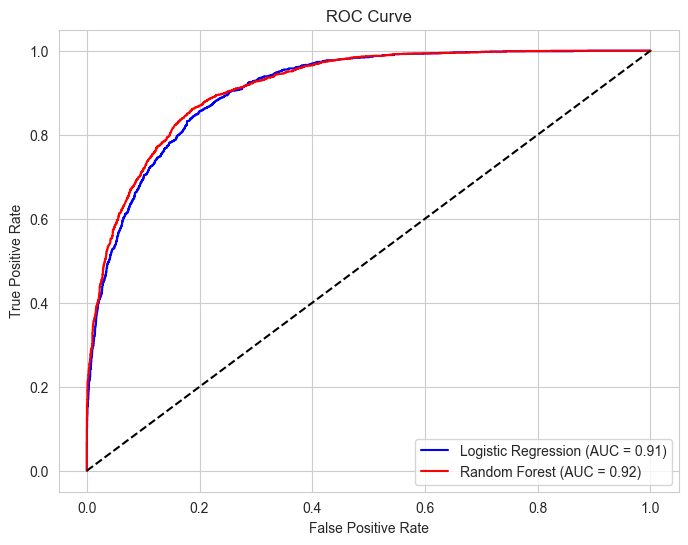

In [104]:
# Plot ROC Curves
import matplotlib.pyplot as plt
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, model_logreg.predict_proba(X_test_fix_rfe)[:, 1], pos_label='>50K')
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rfc.predict_proba(X_test_fix_rfe)[:, 1], pos_label='>50K')

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {logreg_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('ROC Curve.jpg')
plt.savefig('ROC Curve.eps', format='eps', dpi=300)
plt.show()